# Critical Collapse Study

Below is code to help study the formation of black holes. The equations integrated are described in the work by Bloomfield et. al.

arXiv paper on : [1504.02071](https://arxiv.org/pdf/1504.02071.pdf) ([ar5iv](https://ar5iv.org/abs/1504.02071))

For collapse with an approximate QCD equation of state, a previous work is

arXiv: [1801.06138](https://arxiv.org/pdf/1801.06138.pdf) ([ar5iv](https://ar5iv.org/abs/1801.06138))

## Import Modules

In [1]:
import numpy as np
import sys
from importlib import reload 
import scipy.interpolate as interp
import scipy.constants as const

import cython
%load_ext Cython

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)

## Import MS, HM modules

...and reload modules if needed

In [2]:
# importing MS and HM modules. Reload modules if needed
try :
    reload(ms_hm.MS)
    reload(ms_hm.HM)
    reload(ms_hm.QCD_EOS)
except :
    pass

import ms_hm
from ms_hm.QCD_EOS import *
from ms_hm.MS import *
from ms_hm.HM import *

## Various functions that use the MS and HM classes

Functions below compute various things using the Misner-Sharp or Hernandez-Misher classes.

In [3]:
%%cython

import cython
cimport numpy as np

cimport cython
ctypedef np.double_t DTYPE_t

from libc.math cimport exp
from libc.math cimport sqrt

from cython.parallel import prange

@cython.boundscheck(False)  # Deactivate bounds checking
cpdef zero_crossing(np.ndarray x_in, double [::1] y):
    """
    Given an array of inputs y, find x where the function y(x) = 0
    """
    cdef int size = x_in.shape[0]
    cdef double [:] x = x_in
    cdef double w, zero=-1
    cdef int i
    
    for i in range(size-1): # loop through all y values
        if(y[i] * y[i+1] < 0): # if subsequent elements have opposite signs, a zero-crossing was found.
            # linearly extrapolate zero-crossing
            w = abs(y[i] / (y[i+1] - y[i])) 
            zero = x[i] * (1 - w) + x[i+1] * w
            break
            
    return zero

In [4]:
def mix_grid(left, right, n):
    """
    Function to generate coordinate spacings with a mix of uniform and logarithmic spacings,
    with uniform spacing at small values (0 to "left") then logarithmically spaced ("left" to "right").
    
    Returns an array of coordinate positions.
    """
    
    # Generate logarithmically spaced coordinates between "left" and "right"
    A = np.exp(np.linspace(left, right, n))
    dA = A[1] - A[0]
    
    # Generate uniformly spaced coordinates
    A = np.concatenate( (np.linspace(0, A[0], int(np.ceil(A[0] / dA)), endpoint=False), A))
    
    return A

def uni_grid(right, n):
    """
    Function to generate a uniformly-spaced array of coordinate positions
    
    Returns the array of uniformly spaced coordinates.
    """
    A = np.linspace(0, np.exp(right), n)
    return A

def exp_grid(left, right, n):
    """
    Function to generate an exponentially-spaced array of coordinate positions
    """
    # Generate logarithmically spaced coordinates between "left" and "right"
    A = np.logspace(left, right, n)
    A = np.concatenate( ([0], A))

    return A

In [5]:
# Check if a BH forms
# The MS run should proceed until MS until it breaks. If 2m / R > 1, return true
def BH_form(Abar, rho0, amp, default_steps=1500000):
    
    ms = MS(Abar, rho0, amp, trace_ray=False, BH_threshold=-1, sm_sigma=2.0)
    
    if (ms.run_steps(default_steps) == -1):
        return (True, ms.delta)
    
    return (False, ms.delta)

In [6]:
def find_crit(Abar, rho0, lower_amp, upper_amp):
    """
    Binary search between lower and upper to find a critical amplitude
    (Note that this is NOT the critical density)
    return (critical, upper value)
    """    
    for i in range(20):
        middle_amp = (lower_amp + upper_amp) / 2
        print('Iteration No', str(i), ' -- Checking to see if a BH forms at amplitude ' + str(middle_amp))

        if(BH_form(Abar, rho0, middle_amp)[0] == True):
            upper_amp = middle_amp
        else:
            lower_amp = middle_amp
    
    return ((upper_amp + lower_amp) / 2, upper_amp)

In [7]:
def find_mass(Abar, rho0, amp, is_searching_for_crit=False, default_steps=1500000):
    """
    Find mass of BHs for certain amplitude
    set is_searching_for_crit=True when searching for the critical point
    """
    print('Finding mass with amp ' + str(amp))
            
    # Perform a MS run without raytracing
    ms = MS(Abar, rho0, amp, trace_ray=False, BH_threshold=-1e1)
    ms.run_steps(default_steps)
    delta = ms.delta
    
    # Perform a run *with* raytracing to get ICs for an HM run
    ms = MS(Abar, rho0, amp, trace_ray=True, BH_threshold=-1e1)
    flag = ms.run_steps(default_steps)
    if(flag != 0):
        raise ValueError('Not finishing ray-tracing with the amplitude ' + str(amp))
        
    # Perform an HM run
    hm = HM(ms, mOverR=0.99, sm_sigma=50)
    bh_formed = hm.adap_run_steps(550000) == 1
    if(not bh_formed and is_searching_for_crit==False):
        raise ValueError('Cannot get the target 2m/R with the amplitude ' + str(amp))
    
    print(ms.delta, hm.BH_mass2())
    return (ms.delta, hm.BH_mass2())

In [8]:
# # Generate critical scaling data 
# def critical_scaling(crit_amp, lower_amp, upper_amp, n=10):
#     amps = 10**np.linspace(np.log10(lower_amp - crit_amp), np.log10(upper_amp - crit_amp), n) + crit_amp
#     print(amps)
#     masses = np.array([find_mass(amp) for amp in amps])
#     crit_delta = find_mass(crit_amp, is_searching_for_crit=True)[0]  
#     return (masses, crit_delta)

## Simulation setup

Code below will set up grids (arrays) for running the simulations.

The grid of Abar values is linearly spaced from Abar = 0 to 0.5476822525425332 then log spaced until Abar = 3.673077974307203


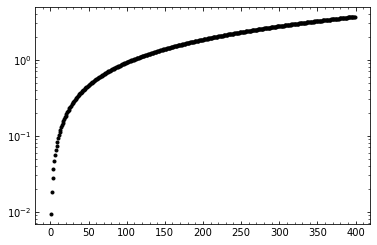

In [9]:
# simulation resolution parameter
# (Not exactly the number of gridpoints for a mixed grid)
n = 400

# Generate an array of coordinate positions for the simulation to run at
lower = np.log10(0.25) # The coordinates will be linearly spaced from 0 to e^lower
upper = np.log10(20) # The coordinates will be log spaced from e^lower to e^upper
# Abar = mix_grid(lower, upper, n)
# Abar = exp_grid(lower, upper, n)
Abar = uni_grid(upper, n)
plt.semilogy(Abar, 'k.')
print("The grid of Abar values is linearly spaced from Abar = 0 to", np.exp(lower),
      "then log spaced until Abar =", np.exp(upper))

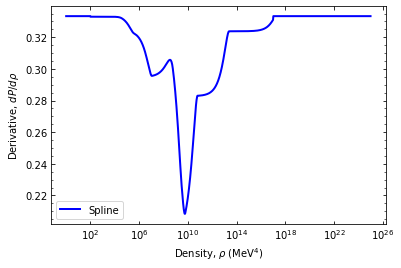

In [14]:
qcd = QCD_EOS()
qcd.dPdrho_plot()

## Scratch Work

Below is some scratch work useful for testing simulations and getting things set up to run

Initial w is [0.22969897] and Horizon radius is [3.45494149e-06]
Not tracing ray and NO excision will be performed!
Horizon was found at step 10670 ! code will be terminated.


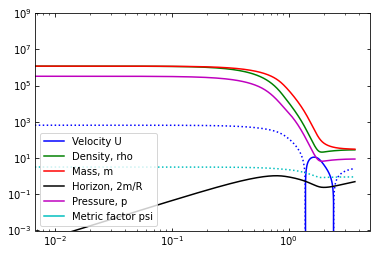

In [10]:
# Reload MS module and try a run
reload(ms_hm.QCD_EOS)
from ms_hm.QCD_EOS import *
reload(ms_hm.MS)
from ms_hm.MS import *
rho0 = 1.0e10 # initial density value in MeV^4, should just be w=1/3 here.
amp = 0.25804443359375

ms = MS(Abar, rho0, amp, trace_ray=False, BH_threshold=-999, sm_sigma=2.0)
ms.run_steps(200000)
ms.plot_fields(True)

In [15]:
rho0 = 1.0e10 # initial density value in MeV^4
find_crit(Abar, rho0, 0.10, 0.30)

Iteration No 0  -- Checking to see if a BH forms at amplitude 0.2
Initial w is [0.22969897] and Horizon radius is [3.45494149e-06]
Not tracing ray and NO excision will be performed!
Density near origin has dropped significantly, so a black hole likely won't be forming! This occurred at step 9182
Iteration No 1  -- Checking to see if a BH forms at amplitude 0.25
Initial w is [0.22969897] and Horizon radius is [3.45494149e-06]
Not tracing ray and NO excision will be performed!
Density near origin has dropped significantly, so a black hole likely won't be forming! This occurred at step 9802
Iteration No 2  -- Checking to see if a BH forms at amplitude 0.275
Initial w is [0.22969897] and Horizon radius is [3.45494149e-06]
Not tracing ray and NO excision will be performed!
Horizon was found at step 8150 ! code will be terminated.
Iteration No 3  -- Checking to see if a BH forms at amplitude 0.2625
Initial w is [0.22969897] and Horizon radius is [3.45494149e-06]
Not tracing ray and NO excisi

/home/jmertens/criticalcollapse/ms_hm/MS.py:97: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt( np.exp(2 * (1 - self.alpha) * xi)


Horizon was found at step 11290 ! code will be terminated.
Iteration No 15  -- Checking to see if a BH forms at amplitude 0.2579742431640625
Initial w is [0.22969897] and Horizon radius is [3.45494149e-06]
Not tracing ray and NO excision will be performed!


ValueError: Large psi detected at step 11287!

In [16]:
# TODO: fix the HM class stuff
# reload(ms_hm.HM)
# from ms_hm.HM import *
# hm = HM(ms, mOverR=0.99, sm_sigma=15)
# hm.adap_run_steps(550000)
# print(hm.BH_mass2())

In [ ]:
# find_mass(0.30, is_searching_for_crit=False)

## Simulation Run

Below is an example of all the code needed to find the critical scaling threshhold and exponent.

In [ ]:
# Find the critical point. It will be bounded between crit and lower.
(crit, lower) = find_crit()
# Find the mass of BHs at various amplitudes between lower_amp and lower_amp plus a bit.
res = critical_scaling(crit, lower_amp, lower_amp + 1e-2, 20)

In [ ]:
(a, b ) = np.polyfit(np.log10(res2[0][:,0] - res2[1])[:], np.log10(res2[0][:,1])[:], deg=1)
plt.scatter(np.log10(res2[0][:,0] - res2[1])[:], np.log10(res2[0][:,1])[:])
plt.plot(np.arange(-3.1,-1.6,0.01), a * np.arange(-3.1,-1.6,0.01) + b)

In [ ]:
np.polyfit(np.log10(res[0][:,0] - 0.4265539636281781)[:], np.log10(res[0][:,1])[:], deg=1)